# Modélisation de la prédiction du prix d'une maison à New York

In [45]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

# Ajoute le chemin du dossier parent à sys.path
notebook_dir = os.path.abspath('..')  # Dossier parent de "notebook/"
sys.path.append(notebook_dir)

from fonctions.fct_importation import *

In [27]:
data = pd.read_csv(r"C:\Users\najim\Documents\Master 2\MLOps\projet\data\data_clean\data_preprocess.csv")
data

,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,BOROUGH
0,Multi-family home for sale,1100000,6,3,2837,Bronx
1,Multi-family home for sale,925000,5,2,2750,Bronx
2,Multi-family home for sale,700000,6,2,3053,Bronx
3,Autre_Type,119000,3,2,2184,Bronx
4,Multi-family home for sale,600000,2,2,2184,Bronx
...,...,...,...,...,...,...
4791,Co-op for sale,280000,2,1,1050,Bronx
4792,Co-op for sale,375000,2,1,2184,Bronx
4793,Co-op for sale,167999,1,1,2184,Bronx
4794,Co-op for sale,309000,2,1,2184,Bronx


# Modélisation

In [28]:
# Définir une fonction pour calculer RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [36]:
def data_split(df : pd.DataFrame):
    
    # Définir les caractéristiques et la cible
    X = data.drop(columns=['PRICE'])  # Caractéristiques (features)
    y = data['PRICE']                 # Cible (target)

    # Séparer les colonnes numériques et catégoriques
    numeric_features = ['BEDS', 'BATH', 'PROPERTYSQFT']
    categorical_features = ['TYPE', 'BOROUGH']
    
    return X, y, numeric_features, categorical_features

X, y, num_features, catg_features = data_split(df= data)

In [37]:
def preprocess_data(features : pd.DataFrame, target : pd.Series, numeric_features : list, categorical_features : list):
    
    print("Construction d'un preprocessor pour transformer les données")
    # Construire un transformer pour traiter les colonnes
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),   # Standardisation des colonnes numériques
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # Encodage OneHot pour les colonnes catégoriques
        ]
    )
    
    display(preprocessor)
    
    return preprocessor

transformer = preprocess_data(features = X, target = y, numeric_features = num_features, categorical_features = catg_features)

Construction d'un preprocessor pour transformer les données


ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['BEDS', 'BATH', 'PROPERTYSQFT']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['TYPE', 'BOROUGH'])])

In [46]:
def modelisation(features : pd.DataFrame, target : pd.Series, preprocessor = transformer):
    
    """
    Fonction pour modéliser les données à l'aide de différents modèles de régression.
    Applique un pipeline avec préprocesseur, ajuste les modèles sur les données d'entraînement
    et évalue les performances sur les données de test.

    Paramètres :
    - features : pd.DataFrame
        Les caractéristiques (features) utilisées pour entraîner les modèles.
    - target : pd.Series
        La cible (target) que les modèles essaieront de prédire.
    - preprocessor : transformer
        Un objet de type ColumnTransformer pour prétraiter les données.

    Retourne :
    - Aucun retour, les résultats sont affichés dans la console.
    """

    # Séparer les données en entraînement et test
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

    # Définir les modèles
    models = {
        "Random Forest": RandomForestRegressor(random_state=42),
        "Neural Network": MLPRegressor(random_state=42, max_iter=500),
        "Linear Regression": LinearRegression()
    }

    # Initialiser un dictionnaire pour stocker les résultats
    results = {}

    for name, model in models.items():
        # Définir le pipeline avec le préprocesseur et le modèle
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        # Ajuster le modèle sur les données d'entraînement
        pipeline.fit(X_train, y_train)
        
        # Prédire sur les données de test
        y_pred = pipeline.predict(X_test)
        
        # Calculer les métriques sur le jeu de test
        test_rmse = rmse(y_test, y_pred)
        test_r2 = r2_score(y_test, y_pred)
        
        # Stocker les résultats
        results[name] = {
            "RMSE (test)": test_rmse,
            "R2 (test)": test_r2
        }

    # Afficher les résultats
    print("Résultats des Modèles :")
    for model, metrics in results.items():
        print(f"Modèle : {model}")
        print(f"  RMSE (test) : {metrics['RMSE (test)']:.2f}")
        print(f"  R2 (test) : {metrics['R2 (test)']:.2f}")
        print("-" * 30)

modelisation(features = X, target = y, preprocessor = transformer)

Résultats des Modèles :
Modèle : Random Forest
  RMSE (test) : 2082412.32
  R2 (test) : 0.49
------------------------------
Modèle : Neural Network
  RMSE (test) : 3306069.33
  R2 (test) : -0.28
------------------------------
Modèle : Linear Regression
  RMSE (test) : 2584675.84
  R2 (test) : 0.21
------------------------------


In [47]:
def optimisation_hyperparametres(features : pd.DataFrame, target : pd.Series, preprocessor = transformer):
    """
    Optimise les hyperparamètres de deux modèles : Random Forest et Réseau de Neurones,
    en utilisant une recherche sur grille avec validation croisée.

    Cette fonction applique un pipeline incluant un préprocesseur (prétraitement des données) 
    et optimise les hyperparamètres des deux modèles via `GridSearchCV`. Elle retourne les 
    meilleurs hyperparamètres pour chaque modèle et affiche les résultats de la recherche.

    Args:
        features (pd.DataFrame): Les caractéristiques (features) utilisées pour entraîner les modèles.
        target (pd.Series): La variable cible (target) que les modèles essaieront de prédire.
        preprocessor (ColumnTransformer): Un objet de type ColumnTransformer appliquant le prétraitement 
                                          des données (standardisation, encodage, etc.).

    Returns:
        tuple: Un tuple contenant :
            - dict : Les meilleurs hyperparamètres pour Random Forest (`meilleurs_estimators_rf`).
            - dict : Les meilleurs hyperparamètres pour le Réseau de Neurones (`meilleurs_estimators_mlp`).

    Prints:
        - Les étapes de l'optimisation.
        - Les meilleurs paramètres et scores obtenus pour chaque modèle.
    """
    
    print("*"*50)
    print("Optimisation des hyperparamètres du RandomForest et du Réseau de Neurone")
    print("*"*50)
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    print("Optimisation du RandomForest en cours ...")
    # Grille de recherche pour Random Forest
    rf_params = {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [10, 20, None]
    }

    rf_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(random_state=42))
    ])

    rf_grid = GridSearchCV(rf_pipeline, rf_params, cv = 4, scoring='neg_mean_squared_error', n_jobs=-1)
    rf_grid.fit(X_train, y_train)
    print("Optimisation du RandomForest terminée.\n")

    print("Optimisation du Réseau de neurone en cours ...")
    # Grille de recherche pour Réseau de Neurones
    mlp_params = {
        'model__hidden_layer_sizes': [(8,), (16, 16), (32,)],
        'model__alpha': [0.0001, 0.001, 0.01],  # Regularization term
        'model__learning_rate_init': [0.001, 0.01]
    }

    mlp_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', MLPRegressor(random_state=42, max_iter=500))
    ])

    mlp_grid = GridSearchCV(mlp_pipeline, mlp_params, cv = 4, scoring='neg_mean_squared_error', n_jobs=-1)
    mlp_grid.fit(X_train, y_train)
    print("Optimisation du Réseau de neurone terminée.")
    print("*"*50)
    
    # Meilleurs hyperparamètres et performances
    print("\nRésultats de l'optimisation des hyperparamètres :")
    print(f"Random Forest - Meilleurs paramètres : {rf_grid.best_params_}")
    print(f"Random Forest - Meilleur RMSE (train cross-val) : {-rf_grid.best_score_:.2f}")

    print(f"Neural Network - Meilleurs paramètres : {mlp_grid.best_params_}")
    print(f"Neural Network - Meilleur RMSE (train cross-val) : {-mlp_grid.best_score_:.2f}")
    
    meilleurs_estimators_rf = rf_grid.best_params_
    meilleurs_estimators_mlp = mlp_grid.best_params_
    
    return meilleurs_estimators_rf, meilleurs_estimators_mlp

best_parameter_rf, best_parameter_mlp = optimisation_hyperparametres(features = X, target = y, preprocessor = transformer)

**************************************************
Optimisation des hyperparamètres du RandomForest et du Réseau de Neurone
**************************************************
Optimisation du RandomForest en cours ...
Optimisation du RandomForest terminée.

Optimisation du Réseau de neurone en cours ...
Optimisation du Réseau de neurone terminée.
**************************************************

Résultats de l'optimisation des hyperparamètres :
Random Forest - Meilleurs paramètres : {'model__max_depth': 10, 'model__n_estimators': 100}
Random Forest - Meilleur RMSE (train cross-val) : 7049675363320.08
Neural Network - Meilleurs paramètres : {'model__alpha': 0.001, 'model__hidden_layer_sizes': (16, 16), 'model__learning_rate_init': 0.01}
Neural Network - Meilleur RMSE (train cross-val) : 11103835041239.51


Visualisation des prédictions pour Random Forest


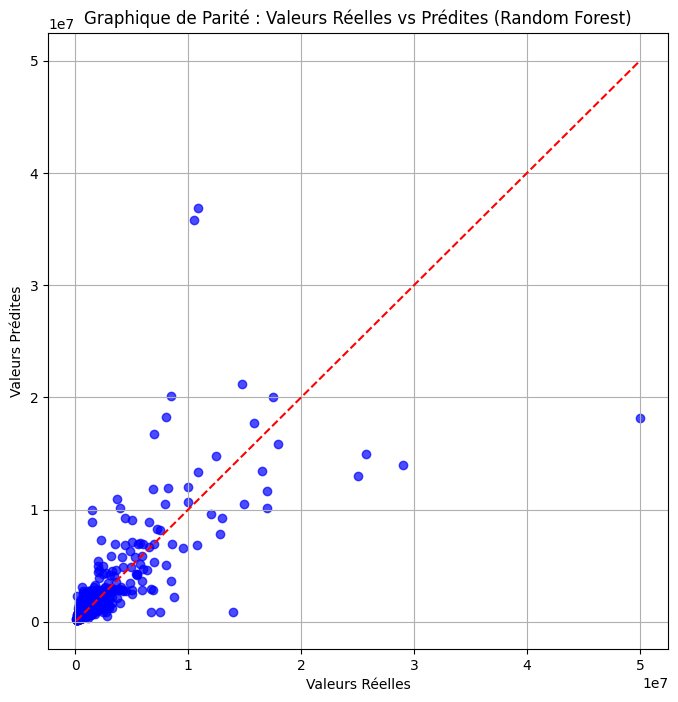

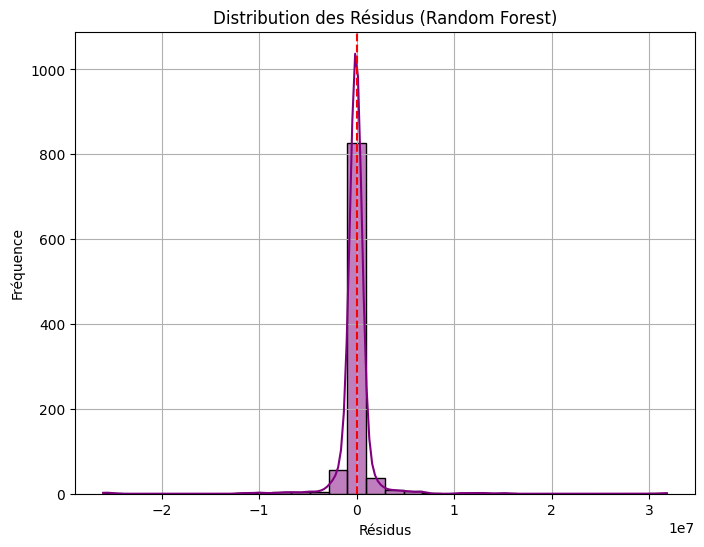

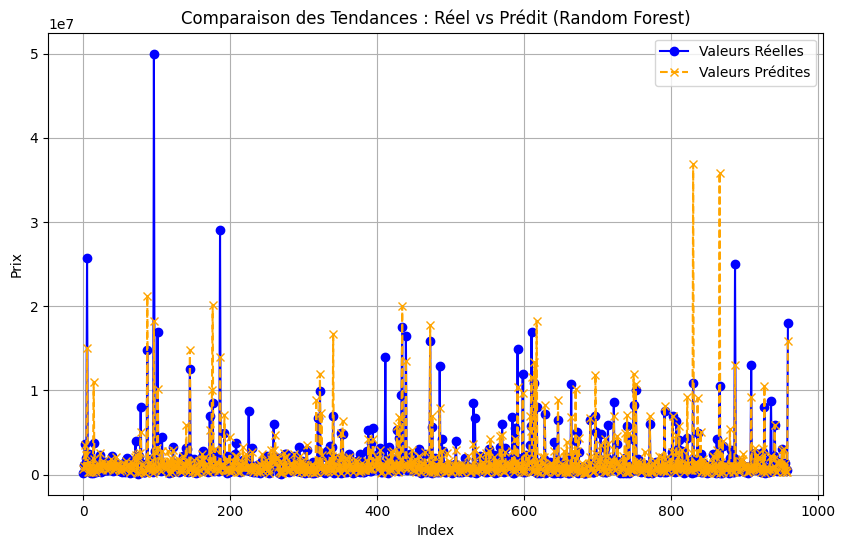

Visualisation des prédictions pour le Réseau de Neurones


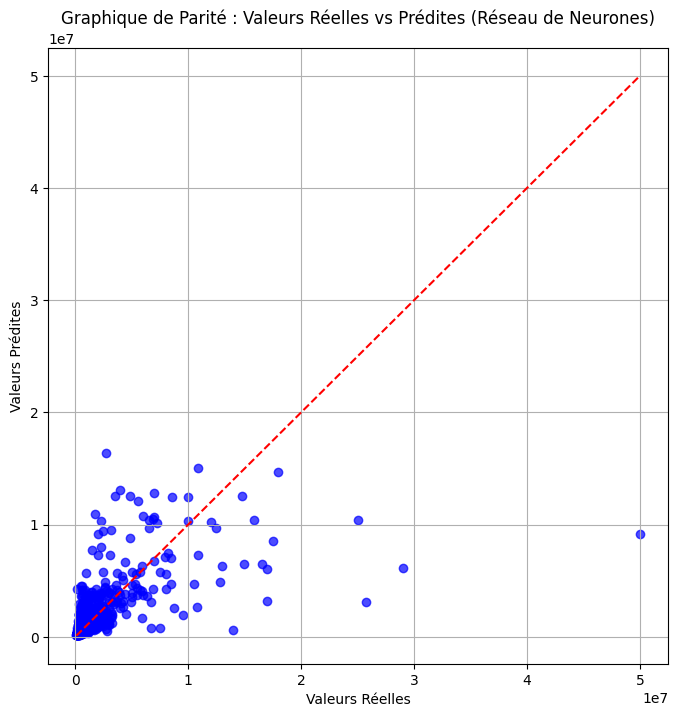

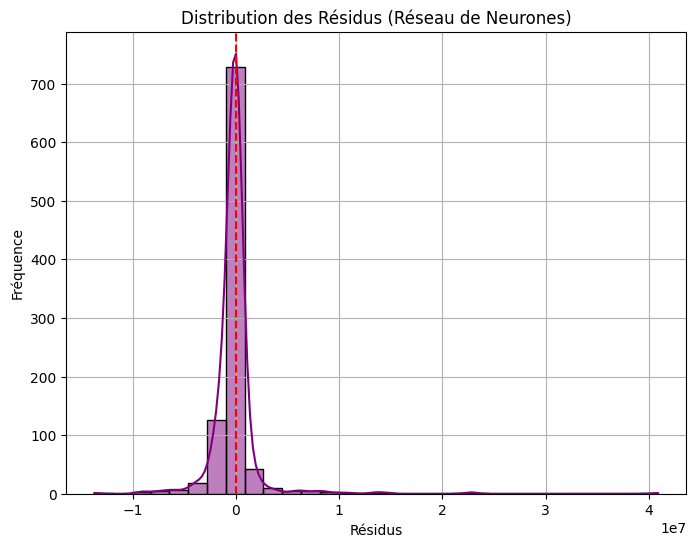

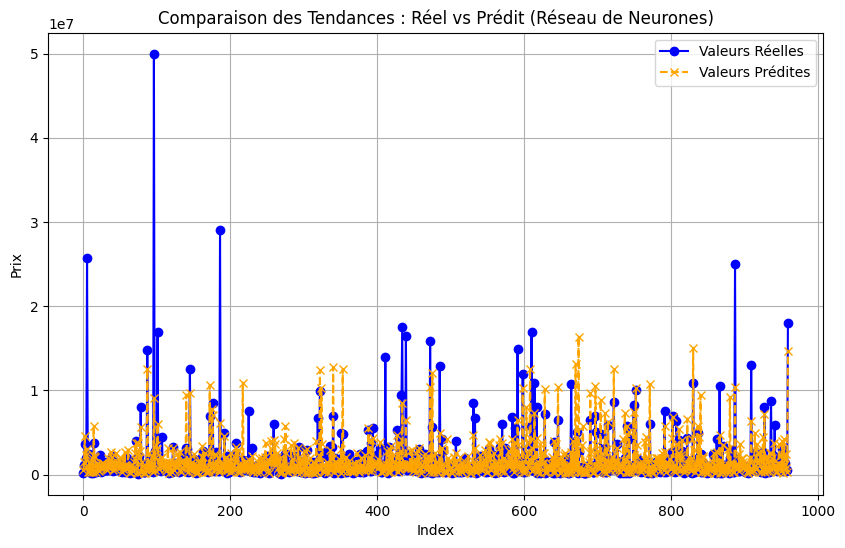

In [52]:
def visualisation_predictions(best_parameters_randomforest, best_parameters_reseau_neurone, preprocessor, X, y):
    """
    Visualise les prédictions des meilleurs modèles (Random Forest et Réseau de Neurones) 
    à l'aide de graphiques : parité, distribution des résidus, et courbe des tendances.

    Args:
        best_parameters_randomforest (dict): Meilleurs hyperparamètres pour Random Forest.
        best_parameters_reseau_neurone (dict): Meilleurs hyperparamètres pour le Réseau de Neurones.
        preprocessor (ColumnTransformer): Préprocesseur pour transformer les données.
        X (pd.DataFrame): Caractéristiques (features) du dataset.
        y (pd.Series): Variable cible (target).

    Returns:
        None: Affiche les graphiques des prédictions.
    """

    # Supprimer le préfixe "model__" des paramètres
    rf_params = {key.replace('model__', ''): value for key, value in best_parameters_randomforest.items()}
    mlp_params = {key.replace('model__', ''): value for key, value in best_parameters_reseau_neurone.items()}

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 1. Pipeline pour Random Forest avec les meilleurs hyperparamètres
    rf_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(random_state=42, **rf_params))
    ])
    rf_pipeline.fit(X_train, y_train)  # Entraînement du modèle
    y_pred_rf = rf_pipeline.predict(X_test)  # Prédictions

    # 2. Pipeline pour Réseau de Neurones avec les meilleurs hyperparamètres
    mlp_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', MLPRegressor(random_state=42, max_iter=500, **mlp_params))
    ])
    mlp_pipeline.fit(X_train, y_train)  # Entraînement du modèle
    y_pred_mlp = mlp_pipeline.predict(X_test)  # Prédictions

    # Visualisation pour Random Forest
    print("Visualisation des prédictions pour Random Forest")
    _visualiser_predictions(y_test, y_pred_rf, title="Random Forest")

    # Visualisation pour Réseau de Neurones
    print("Visualisation des prédictions pour le Réseau de Neurones")
    _visualiser_predictions(y_test, y_pred_mlp, title="Réseau de Neurones")

def _visualiser_predictions(y_test, y_pred, title):
    """
    Fonction utilitaire pour générer les graphiques de parité, résidus et tendances.

    Args:
        y_test (pd.Series): Valeurs réelles de la cible.
        y_pred (np.ndarray): Valeurs prédites par le modèle.
        title (str): Titre à afficher pour les graphiques.

    Returns:
        None: Affiche les graphiques.
    """

    # 1. Graphique de parité (Réel vs Prédit)
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.7, color="blue")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Ligne y=x
    plt.title(f"Graphique de Parité : Valeurs Réelles vs Prédites ({title})")
    plt.xlabel("Valeurs Réelles")
    plt.ylabel("Valeurs Prédites")
    plt.grid(True)
    plt.show()

    # 2. Histogramme des résidus (Erreurs)
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True, color="purple", bins=30)
    plt.title(f"Distribution des Résidus ({title})")
    plt.xlabel("Résidus")
    plt.ylabel("Fréquence")
    plt.axvline(0, color='red', linestyle='--')  # Ligne verticale à 0
    plt.grid(True)
    plt.show()

    # 3. Courbe des valeurs réelles et prédites
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label="Valeurs Réelles", marker='o', linestyle='-', color="blue")
    plt.plot(y_pred, label="Valeurs Prédites", marker='x', linestyle='--', color="orange")
    plt.title(f"Comparaison des Tendances : Réel vs Prédit ({title})")
    plt.xlabel("Index")
    plt.ylabel("Prix")
    plt.legend()
    plt.grid(True)
    plt.show()

# Exemple d'appel
visualisation_predictions(
    best_parameters_randomforest=best_parameter_rf,
    best_parameters_reseau_neurone=best_parameter_mlp,
    preprocessor=transformer,
    X=X,
    y=y
)